# Tuning a Variational Autoencoder with Bayesian Optimization

The last decade has witnessed several interesting ideas in optimization of various functions, that are ubiquitous in machine learning. Bayesian Optimization, also known as surrogate modelling, is a particularly interesting technique to optimize black box functions (<a href="https://www.cs.ox.ac.uk/people/nando.defreitas/publications/BayesOptLoop.pdf">Shahriari et al., 2012</a>).

These notes will take a look at how to optimize an expensive-to-evaluate function, which will return the predictive performance of an Variational Autoencoder (VAE). We will optimize one of the hyperparameters defining the VAE - the $l_2$ regularization parameter. This type of applications of Bayesian optimization are referred to as <i>automatic machine learning</i>.



Perhaps the most interesting part of the tutorial is the definition of a surrogate model as a <i>probabilistic program</i>, using the rapidly-emerging modelling language, STAN (<a href="https://www.jstatsoft.org/article/view/v076i01">Carpenter et. al, 2017</a>), which neatly implements automatic differentiation and a Hamiltonian Monte Carlo (HMC) sampler. This way, we are able to learn various nuisance parameters, such as black-box function related variance and lengthscales in a semi-automated way.

This post and some figures are based on a previous post explaining the implementation of <a href="https://blog.keras.io/building-autoencoders-in-keras.html">VAEs with Keras</a>. The relevant terminology for Bayesian optimization can be found in the <a href="https://towardsdatascience.com/the-intuitions-behind-bayesian-optimization-with-gaussian-processes-7e00fcc898a0"> Intuitions behind Bayesian Optimization with GPs</a> post.

<br/>
<figure>
<img src="img/tnp.jpg"/>
<figcaption align="right"><font color="gray">Multiple local maxima and minima in the Triglav National Park, Slovenia, overlooking the Bohinj lake.   </font></figcaption>
</figure>


#### Prerequisites


To run the examples in this notebook, we will use some external libraries; a framework to build neural network-like models, <a href="https://keras.io">Keras</a>, the Python interface for <a href="https://pystan.readthedocs.io/en/latest/">STAN</a>, and the <a href="https://matplotlib.org">Matplotlib</a>, <a href="http://www.numpy.org">NumPy</a>, <a href="https://www.scipy.org">SciPy</a> trio. On top of that, we will use two custom implementations of the Variational autoencoder <a href="vae.py">`vae.py`</a>, and a Gaussian Process <a href="gp.py">`gp.py`</a>.

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from pystan import StanModel
from keras.datasets import mnist
from vae import VAE
from gp import GP
from scipy.stats import multivariate_normal as mvn
from scipy.spatial.distance import cdist

## Variational Autoencoder and simple image data set 

To start off, we will define our machine learning scenario. Briefly, a Variational Autoencoder (VAE) takes data vectors on the input, pushes them through an <i>encoding function</i> to obtain a low dimensional (latent) representation, and 
finally uses a <i>decoding function</i> to approximate original vectors given the latent representation. Both the encoder and the decoder are often implemented using neural networks, which is nowadays quite simple using tools like Keras.

<img src="./img/vae.jpg"/>

Our toy dataset will be composed of tens of thousands of small $28 \times 28$ pixel images containing hand-written digits.

<img src="./img/digits.png"/>

In [77]:
# MNIST data set
(img_train, label_train), (img_test, label_test) = mnist.load_data()

# Original image dimension - need to reconstruct when plotting.
image_dim = (img_train.shape[1], img_train.shape[2])
original_dim = img_train.shape[1] * img_train.shape[2]

img_train = np.reshape(img_train, [-1, original_dim])
img_test = np.reshape(img_test, [-1, original_dim])
img_train = img_train.astype('float32') / 255
img_test = img_test.astype('float32') / 255

# Set a fixed random seed
np.random.seed(0)

Our variational autoencoder will use a latent dimension of 1 for illustration purposes. Crucially, it will be dependent on a scalar regularization parameter, $\alpha > 0$, that controls for model complexity. This parameter plays a familiar role in many machine learning models.

We define a function that returns the model class and a value that quantifies loss on validation data. This is the <b>black-box</b> function $f$ that we will try to minimize by exploration of the space where $\alpha$ lives.

In [78]:
def score_parameters(img_train, img_test, original_dim,
                     **kwargs):
    """ Train the autoencoder and return score. """
    factory = VAE(original_dim=original_dim, latent_dim=1, **kwargs)
    vae = factory.compile()
    vae.fit(img_train,
           epochs=10,
           batch_size=30,
           validation_data=(img_test, None),
           verbose=False)
    return factory, vae, vae.history.history["val_loss"][-1]

We define what we deem a suitable range where $\alpha$ would produce reasonable models. Say this range is equal to the interval $[10^{-10}, ..., 10^{-3}]$. As is often done, we will explore the space of candidate $\alpha$ in the log space, so the sample space under investigation is denoted $\mathbf{X} = [-10,...,-3]$, and $\alpha = 10^x$ for some $x \in \mathbf{X}$.



In [79]:
# Optimization parameters
n = 1000
delta = 3
iterations = 10
X = np.linspace(-10, -3, n).reshape((n, 1))

To get a feeling how the models behave under different parameter values, let's sample a couple of <i>look-ahead</i> points within the domain. These will be used to get an initial idea of the surface of our black box function.  The function takes a couple of minutes to run, which we chose on purpose to advocate the utility of Bayesian optimization. 

In [80]:
lookahead = [20, 500, 980]

# Evaluate model for a sample of points
scores = [score_parameters(img_train,
                           img_test,
                           original_dim, alpha1=10**X[i])[-1] for i in lookahead]

The validation loss is clearly dependent on $\alpha$, suggesting a minimum value somewhere within the pre-specified domain.

In [81]:
for ai, f in zip(lookahead, scores):
    print("Index: %d\talpha: %.2e\tloss f(x): %.2f" % (ai, 10**X[ai, 0], f))

Index: 20	alpha: 1.38e-10	loss f(x): 172.91
Index: 500	alpha: 3.19e-07	loss f(x): 172.38
Index: 980	alpha: 7.36e-04	loss f(x): 173.68


<br/>
<br/>

## Bayesian optimization of a black-box function

To implement Bayesian optimization of a black box function, we usually need the following ingredients:
* <b>A surrogate model.</b> A model of the black box function we want to optimize. The model shall return both the mean prediction as well as the predicted variance of the function values. A convenient model is the Gaussian Process (GP).
* <b>A covariance function (kernel)</b>. Gaussian Processes are defined with the mean function and the covariance function. A covariance function is a bivariate function that returns and estimate of the coavariance between two input points.
* <b>An acquisition function</b>. Combines the predicted mean and variance to reveal where to evaluate the black box function next. It is designed to trade-off <i>exploration</i> (regions of high variance - uncertainty) and <i>exploitation</i> (regions of high predicted mean value).

### Gaussian Process as a surrogate model

The uncertainty in the values of $f(x)$ is quantified using a Gaussian Process (GP), that links the parameter values $x$ to the observed scores $y \propto f(x)$. A GP is a multivariate Normal distribution that is specified by the mean and covariance functions, both dependent on $x$.


$$
f(x) \sim \mathcal{N}(\mu(x), \Sigma(x))
$$

The mean function $\mu(x)$ will be taken as constant, specifically the average of currently observed scores. The covariance function $\Sigma(x)$, or the <i>kernel</i> will be defined as 

$$ k(x, x') = \text{exp}(-\frac{\|x-x'\|^2}{\ell^2}) $$.

This is a well-known kernel that induces dependencies between values of $x$ that are close in $\mathcal{X}$. The closeness is in turn controlled by the lengthscale hyperparameter $\ell$.

In [82]:
def exponential_kernel(X, Y, bandwidth=1.0, lengthscale=1.0):
    """
        :param X: Array of shape (n_samples, n_features)
        :param Y: Array of shape (n_samples, n_features)
        :param bandwidth: (``float``) Bandwidth.
        :return: Kernel matrix between data points.
    """
    return np.exp(- cdist(X, Y, metric="euclidean") ** 2 / lengthscale ** 2)

Here is how the kernel function looks like for a fixed value $x_0=-6$ and different values of the lengthscale. Clearly, larger lengthscales induces long range dependencies between different values of $x$. The key trick presented here will be to infer $\ell$ automatically.

Evaluating $k(x, x')$ for all pairs $x, x' \in X$ yields the kernel matrix $\mathbf{K}$.

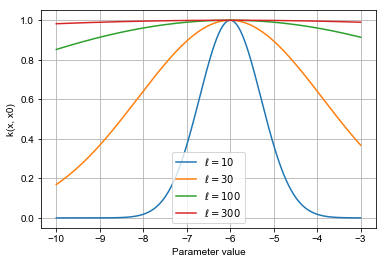

In [83]:
x0 = np.atleast_2d(-6)

k_1 = exponential_kernel(X, x0, lengthscale=1)
k_3 = exponential_kernel(X, x0, lengthscale=3)
k_10 = exponential_kernel(X, x0, lengthscale=10)
k_30 = exponential_kernel(X, x0, lengthscale=30)

plt.figure()
plt.xlabel("Parameter value")
plt.ylabel("k(x, x0)")
plt.plot(X, k_1, "-", label="$\\ell=10$")
plt.plot(X, k_3, "-", label="$\\ell=30$")
plt.plot(X, k_10, "-", label="$\\ell=100$")
plt.plot(X, k_30, "-", label="$\\ell=300$")
plt.legend()
plt.grid()

The final part of the specification is the relationship between noisy observation of target values $\mathbf{y}$ and the function values $f(\mathbf{X})$. In a Gaussian process, this is usually done be adding variance parameters that introduce noise in the observations.

$$
    \mathbf{y} \sim \mathcal{N}({\mu(\mathbf{X}), \mathbf{\Sigma}})
$$

where the covariance matrix $\mathbf{\Sigma} =  \sigma_{\text{signal}} \mathbf{K} + \sigma_{\text{noise}} \mathbf{I}$ and $\mathbf{K}$ is the kernel matrix obtained by evaluating the kernel function for all pairs of $x, x' \in \mathbf{X}$ and $\mathbf{I}$ is the indentity matrix.

### Hyperparameter priors

There are now three hyperparameters that we have to set: the lengthscale $\ell$, the noise variance $\sigma_{\text{noise}}$ and the signal variance $\sigma_{\text{signal}}$. 
One option is to optimize respective values using techniques like gradient descent. Although that would probably give us sensible estimates, we introduce a solution based on sampling from the posterior distribution, conditioned on observations of the target values. 

The Gaussian process models enable a straightforward calculation of the <i>likelihood function</i> - probability of the data given the model, i. e.

$$ p(\mathcal{y}|X, \ell, \sigma_{\text{noise}}, \sigma_{\text{signal}}) = \mathcal{N}(f(\mathbf{X}), \mathbf{\Sigma}) $$

which we already seen above. Specifying <i>prior</i> distributions for the parameters would allow us to use Bayesian theorem to derive <i>posterior</i> distributions, e.g.

$$ p(\ell, \sigma_{\text{noise}}, \sigma_{\text{signal}}) \propto p(\mathcal{y}|X, \ell, \sigma_{\text{noise}}, \sigma_{\text{signal}})p(\ell, \sigma_{\text{noise}}, \sigma_{\text{signal}}) $$.

It has long been known that introducing appropriate (conjugate) prior distributions would make the above equation to have a tractable form. Tools like STAN allow us more freedom in specifying prior distribution, and the underlying machinery takes care of the derivations. 

$$ \text{log}(\ell) \sim \mathcal{N}(\mu_{\ell}, \sigma^2_{\ell}) $$ 

$$ \text{log}(\sigma_{\text{noise}}) \sim \mathcal{N}(\mu_{\text{noise}}, \sigma^2_{\text{noise}}) $$

$$ \text{log}(\sigma_{\text{signal}}) \sim \mathcal{N}(\mu_{\text{signal}}, \sigma^2_{\text{signal}}) $$

where the parameters on the right hand size are hyperparameters. Instead of fixed initial values, specifying whole distributions of values allows for greater flexibility in finding suitable values. Note that other prior distributions are possible (e.g. Gamma), as long as they are defined for strictly positive real numbers.
 
Still, we could introduce the general prior knowledge that the signal variance is sligthly greater than noise. 
Let's set some example initial values.


In [85]:
mu_noise = -4
sd_noise = 1
mu_signal = 1
sd_signal = 2

mu_lengthscale = 0
sd_lengthscale = 1.5

An important thing to note is that we are setting the signal variance to be on average higher than the noise variance. This is to be expected if the underlying function contains any regularity at all.

Also important is the lengthscale distribution; The value of this parameter will determine the extent to which different values of the input space have influence on the scoring function.

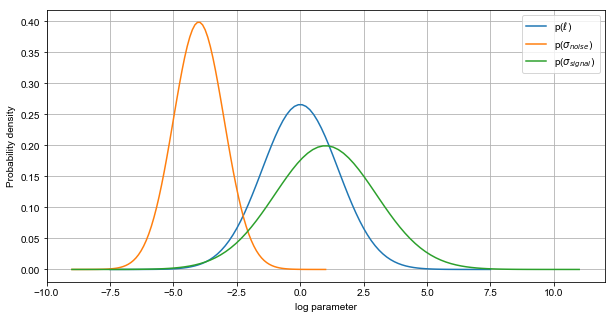

In [86]:
t_lengthscale = np.linspace(mu_lengthscale-5*sd_lengthscale, mu_lengthscale+5*sd_lengthscale, 100)
pdf_lengthscale = mvn.pdf(t_lengthscale, mean=mu_lengthscale, cov=sd_lengthscale**2)

t_noise = np.linspace(mu_noise-5*sd_noise, mu_noise+5*sd_noise, 100)
pdf_noise = mvn.pdf(t_noise, mean=mu_noise, cov=sd_noise**2)

t_signal = np.linspace(mu_signal-5*sd_signal, mu_signal+5*sd_signal, 100)
pdf_signal = mvn.pdf(t_signal, mean=mu_signal, cov=sd_signal**2)

plt.figure(figsize=(10, 5))
plt.plot(t_lengthscale, pdf_lengthscale, label="p($\\ell$)")
plt.plot(t_noise, pdf_noise, label="p($\\sigma_{noise}$)")
plt.plot(t_signal, pdf_signal, label="p($\\sigma_{signal}$)")
plt.legend()
plt.xlabel("log parameter")
plt.ylabel("Probability density")
plt.grid()
plt.show()

### The Monte Carlo sampler

We now have everything we need to specify a Monte Carlo sampler with STAN. The code below is self-explanatory, recapitulating the paragraphs above.

In [55]:
stan_code = """

data {
  int<lower=1> N;       // Number of data points
  int<lower=1> D;       // Input space dimensionality
  matrix[N, D] X;       // Input design matrix
  vector[N] y;          // Target vector

  // Gamma hyperparameters
  real mu_noise;
  real sd_noise;
  real mu_signal;
  real sd_signal;
  real mu_lengthscale;
  real sd_lengthscale;
}

transformed data {
  vector[N] mu;
  for (i in 1:N) mu[i] = mean(y);
}

parameters {
  real log_lengthscale;
  real log_noise;
  real log_signal;
}

transformed parameters{
    real lengthscale;
    real noise;
    real signal;
    lengthscale = exp(log_lengthscale);
    noise = exp(log_noise);
    signal = exp(log_signal);
}

model {
    matrix[N, N] Sigma;
    log_noise ~ normal(mu_noise, sd_noise);
    log_signal ~ normal(mu_signal, sd_signal);
    log_lengthscale ~ normal(mu_lengthscale, sd_lengthscale);

    for (i in 1:N){
        for (j in 1:N){
            Sigma[i, j] = exp(-square(1.0 / lengthscale) * square(dot_self(X[i] - X[j])));
        }
    }
    Sigma = signal * Sigma + diag_matrix(rep_vector(noise, N));

    // GP
    y ~ multi_normal(mu, Sigma);
}
"""

The stan model is ready for compiling.

In [32]:
sm = StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e7a9f87c5c9ea54918d8e90cf83109d5 NOW.


Given some evaluations of the scoring function that we have invested in above, we can now efficiently sample the possible values of the hyperparameters. This gives us a posterior distribution of all three parameters, rather than a single value.

In [87]:
def sample_hyperparameters(X, y, lookahead):
    """ Sample hyperparameters with the Stan model. """
    fit = sm.sampling(data={"X": X[lookahead], "y": y, "D": 1, "N": len(y),
                            "mu_noise": mu_noise,
                            "sd_noise": sd_noise,
                            "mu_signal": mu_signal,
                            "sd_signal": sd_signal,
                            "mu_lengthscale": mu_lengthscale,
                            "sd_lengthscale": sd_lengthscale,})
    noise_post = np.mean(fit["noise"])
    signal_post = np.mean(fit["signal"])
    lengthscale_post = np.mean(fit["lengthscale"])
    return noise_post, signal_post, lengthscale_post

y = np.array(scores).ravel()
noise_post, signal_post, lengthscale_post = sample_hyperparameters(X, y, lookahead[:3])

print("Noise variance (posterior mean): %.3f" % noise_post)
print("Signal variance (posterior mean): %.3f" % signal_post)
print("Lengthscale (posterior mean): %.3f" % lengthscale_post)

/Users/martins/Dev/py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Noise variance (posterior mean): 0.031
Signal variance (posterior mean): 0.982
Lengthscale (posterior mean): 1.872


Note that the posterior mean of the signal is greater than the mean of the noise, which indicates that there migh be some regularity in our black-box function. Given these values, we can fot a GP regression model over the space of considered parameters, giving us an estimate of the mean and (importantly) the variance - <i>uncertainty</i> - of the predictions at each $x$.

Hold tight for a visualization that follows soon!

In [88]:
def fit_gp(X, y, lookahead, noise_var, signal_var, lengthscale):
    Kx = exponential_kernel(X, X, lengthscale=lengthscale)
    gp = GP(noise=noise_var, signal=signal_var)
    gp.fit(Kx[lookahead, :][:, lookahead], y)
    ym, yv = gp.predict(Kx[:, lookahead], np.diagonal(Kx))
    return ym, yv
    
ym, yv = fit_gp(X, y, lookahead, noise_post, signal_post, lengthscale_post)

To minimize the loss function using our newly inferred surrogate model - the GP - we need a way to determine which point in the parameter space is worthy of sampling. This requires balancing the mean prediciton (where we believe the function values are low) and uncertainty (unexplored regions). This is known as the exploitation/exploration trade-off and is realized by using an <i>acquisition function</i>.

A commonly used acquisition function is the <i>Expected improvement</i>, that calculates the probability
$p(f(x) < \tau)$ for some predefined threshold $\tau$. Typically, $\tau$ will be set to the minimal observed value so far.

In [89]:
def ei(mu, std, tau):
    """
    Calculate expected improvement.
    :param mu: mu(x)
    :param std: std(x)
    :param tau: lower bound.
    :return:
    """
    z = (mu.ravel() - tau) / std.ravel()
    return (mu.ravel() - tau) * mvn.cdf(z) + std.ravel() * mvn.pdf(z)


<font color="green"><b>Note   </b></font> The acqusition function is dependent on the mean and the variance of our posterior predictive distribution. The former is based on a single instantiation of the three parameters - the posterior means.  We could improve this process by using <i>integrated acquisition</i>, that is, computing the acquistion for each single sample of parameters returned by the sampler and averaging the result.

In [90]:
def compute_acquisition(ym, yv):
    """ Compute acquisition function and return next candidates """
    aq = ei(mu = -ym, std=np.sqrt(yv), tau=max(-ym))
    aq[lookahead] = -np.inf
    xnew = np.argmax(aq)
    return aq, xnew

aq, xnew = compute_acquisition(ym, yv)

We can finally visualize our observed scores, the surrogate GP model and the acquisition funciton (below). Notice how uncertainty increases in the regions far from the points where we have observed the black box function value. The acquisition funtion will recommend sampling the next value of $f$ where the model predicts low values, but also displays high uncertainty. This happes at some point $x_{\text{new}}$.

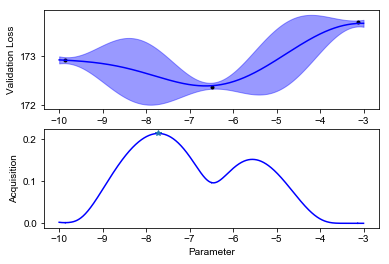

In [92]:
def plot_fit(X, y, lookahead, ym, yv, aq, title=""):
    """ Plot the model fit and the acquisition function. """
    fig, ax = plt.subplots(nrows=2, ncols=1)
    ax[0].set_title(title)
    ax[0].plot(X[lookahead], y, ".", color="black")
    ax[0].plot(X, ym, "-", color="blue")
    ax[0].fill_between(X.ravel(), ym.ravel()-yv.ravel(), ym.ravel()+yv.ravel(), color="blue", alpha=0.4)
    ax[0].set_ylabel("Validation Loss")
    ax[1].plot(X.ravel(), aq, color="blue")
    ax[1].plot(X[xnew], aq[xnew], "*")
    ax[1].set_ylabel("Acquisition")
    ax[1].set_xlabel("Parameter")
    
plot_fit(X, y, lookahead, ym, yv, aq)

We can evaluate the funciton value at $x_{\text{new}}$, update our lookahead set and model. The visualized the updated model, you can re-run all the cells above.

In [93]:
# Add to look-ahead and compute scores
lookahead = np.array(list(lookahead) + [xnew])
sc = score_parameters(img_train, img_test, original_dim, alpha1=10**X[xnew, 0])[-1]
scores.append(sc)
for ai, s in zip(lookahead, scores):
    print("Index: %d\talpha: %.2e\tloss:%.2f" % (ai, 10**X[ai, 0], s))

Index: 20	alpha: 1.38e-10	loss:172.91
Index: 500	alpha: 3.19e-07	loss:172.38
Index: 980	alpha: 7.36e-04	loss:173.68
Index: 325	alpha: 1.89e-08	loss:172.71


### An iterative optimization algorithm (Thompson sampling)
We are ready to define an iterative algorithm to optimize the model loss in a Bayesian optimization manner. The acquisition function dictates which point to select next, tradig off exploration and exploitation. The final recommendation - the predicted optimum - is taken to be the maximum of the related GP fit. This iterative procedure of sampling and updating the model is known as Thompson sampling.

This will take a couple of minutes (depending of hardware), which is exactly the scenario where you want to use Bayesian optimization.

/Users/martins/Dev/py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Step: 0	evaluated point: 1	next score: 172.826
Step: 1	evaluated point: 2	next score: 171.534
Step: 2	evaluated point: 3	next score: 172.624
Step: 3	evaluated point: 4	next score: 172.952
Step: 4	evaluated point: 5	next score: 173.388
Step: 5	evaluated point: 6	next score: 173.052
Step: 6	evaluated point: 7	next score: 173.040
Step: 7	evaluated point: 8	next score: 172.895
Step: 8	evaluated point: 9	next score: 172.833
Step: 9	evaluated point: 10	next score: 172.737


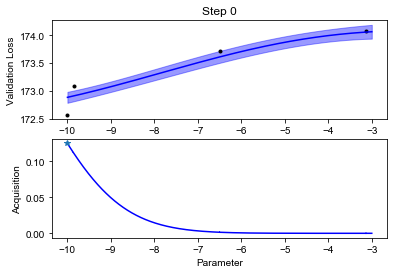

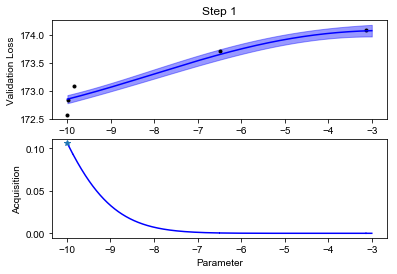

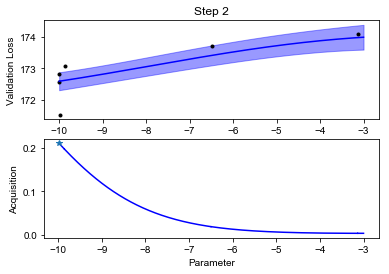

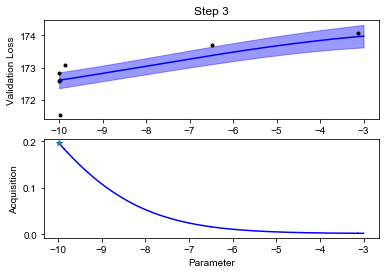

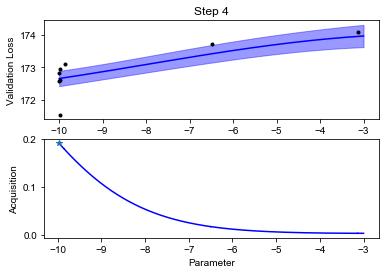

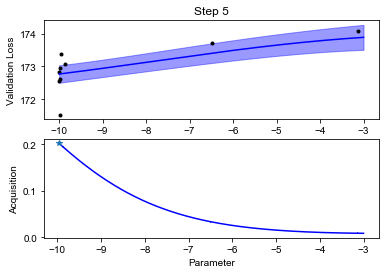

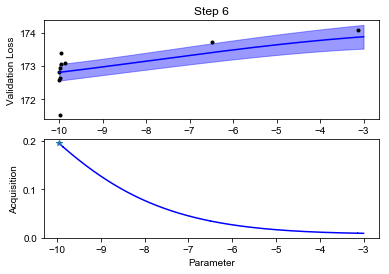

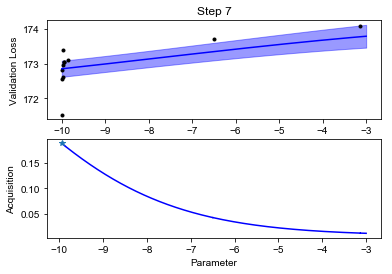

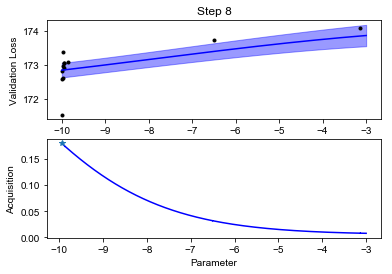

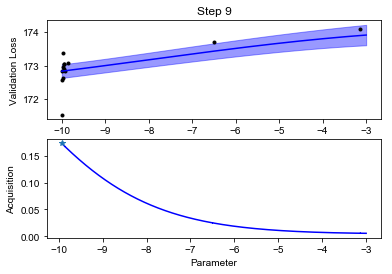

In [39]:
# Select initial evaluations
scores = np.array(scores).ravel()

# Iterate 10 times
for step in range(10):
    noise_post, signal_post, lengthscale_post = sample_hyperparameters(X, scores, lookahead)
    ym, yv = fit_gp(X, scores, lookahead, noise_post, signal_post, lengthscale_post)
    aq, xnew = compute_acquisition(ym, yv)

    plot_fit(X, scores, lookahead, ym, yv, aq, title="Step %d" % step)

    iscore = score_parameters(img_train, img_test, original_dim, alpha1=10**X[xnew, 0])[-1]
    lookahead = np.array(list(lookahead) + [xnew])
    scores = np.array(list(scores) + [iscore])
    
    print("Step: %d\tevaluated point: %d\tnext score: %.3f" % (step, xnew, iscore))

Notice how the optimization will lock in the regions where the function value is low after an initial exploration phase.

Finally, we can plot how our Variational Autoencoder is performing by sampling some images. We can see the perceived order of digits that now live in the latent 1D space. Note that in the original tutorial, the authors used a 2D latent space and are able to reconstruct the digits 0-9 even more precisely.

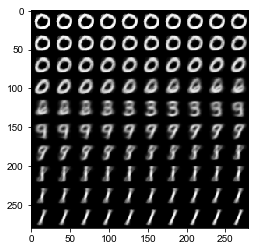

In [40]:
ibest = np.argmin(ym)
factory, model, _ = score_parameters(img_train, img_test, original_dim, alpha1=10**X[ibest, 0])
factory.plot_results_1D()

## Conclusion

Bayesian optimization is the method of choice for optimization of expensive-to-evaluate, black-box function. Specifying a surrogate GP model with STAN takes care of sampling necessary parameters and allows for fine control of possible parameter values. 

Replacing the `score_parameters` with a custom function should make this notebook useful for optimizing an arbitrary process and parameters.

## References

Shahriari, B., et al. "Taking the human out of the loop: A review of bayesian optimization." Proceedings of the IEEE 104.1 (2016): 148-175.

Carpenter, Bob, et al. "Stan: A probabilistic programming language." Journal of statistical software 76.1 (2017).